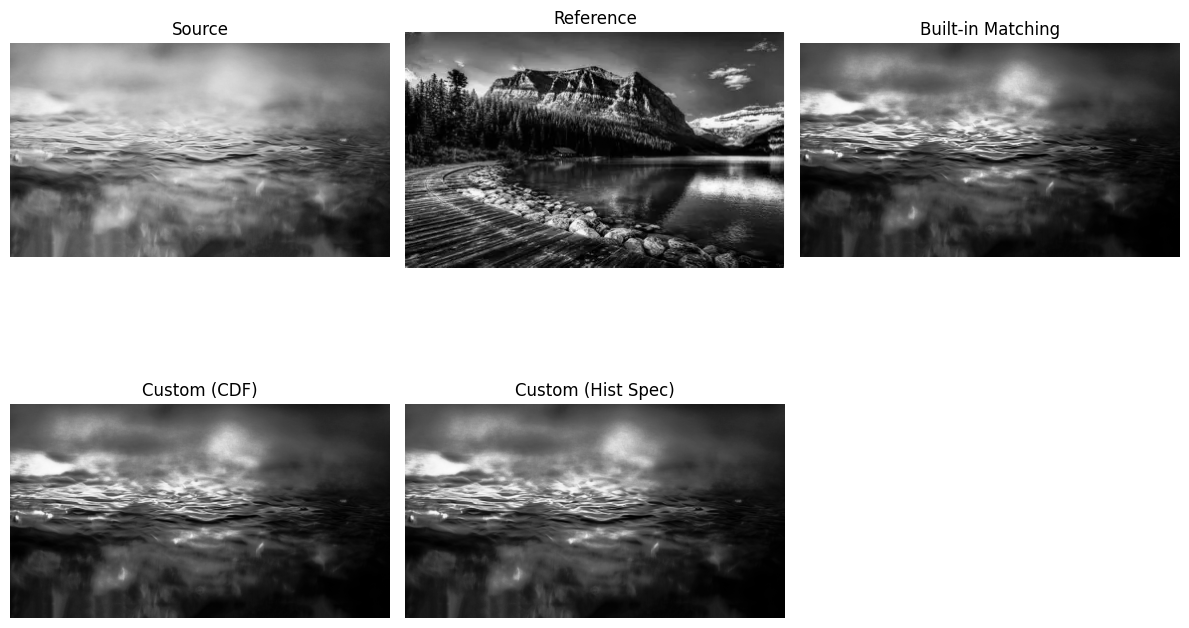

In [1]:
#================= Importing necessary libraries ======================
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage import exposure


#================= Built-in Histogram Matching (scikit-image) ======================
def hist_matching_builtin(source, reference):
    matched = exposure.match_histograms(source, reference, channel_axis=None)
    # (FIX) ensure uint8 for consistent display/processing
    matched = np.clip(matched, 0, 255).astype(np.uint8)
    return matched

#================= Custom Histogram Matching (CDF-based) ======================
def hist_matching_cdf(source, reference):
    src = source.ravel()
    ref = reference.ravel()

    s_values, bin_idx, s_counts = np.unique(src, return_inverse=True, return_counts=True)
    r_values, r_counts          = np.unique(ref, return_counts=True)

    s_quantiles = np.cumsum(s_counts).astype(np.float64) / src.size
    r_quantiles = np.cumsum(r_counts).astype(np.float64) / ref.size

    interp_r_values = np.interp(s_quantiles, r_quantiles, r_values)
    matched = interp_r_values[bin_idx].reshape(source.shape)
    return np.clip(matched, 0, 255).astype(np.uint8)

#================= Custom Histogram Matching (Histogram Specification) ======================
def hist_matching_hist_spec(source, reference, nbins=256):
    # (FIX) explicit range for uint8 images
    src_hist, bins = np.histogram(source.flatten(), nbins, range=(0,255), density=True)
    ref_hist, _    = np.histogram(reference.flatten(), nbins, range=(0,255), density=True)

    src_cdf = np.cumsum(src_hist);  src_cdf /= src_cdf[-1]
    ref_cdf = np.cumsum(ref_hist);  ref_cdf /= ref_cdf[-1]

    gray_levels = np.linspace(0, 255, nbins)
    mapping = np.interp(src_cdf, ref_cdf, gray_levels)

    src_bin_idx = np.digitize(source.flatten(), bins) - 1
    src_bin_idx = np.clip(src_bin_idx, 0, nbins-1)

    matched = mapping[src_bin_idx].reshape(source.shape)
    return np.clip(matched, 0, 255).astype(np.uint8)

#================= (Optional) contrast helpers if you want true low/high titles ======================
def make_low_contrast(img):
    x = img.astype(np.float32) / 255.0
    y = np.clip(x * 0.5 + 0.25, 0, 1)
    return (y * 255.0).astype(np.uint8)

def make_high_contrast(img):
    x = img.astype(np.float32) / 255.0
    y = np.clip(np.power(x, 0.6), 0, 1)
    return (y * 255.0).astype(np.uint8)

#================= Execution workflow ======================
def main():
    # (FIX) use valid, consistent paths (examples)
    src_path = r"/source.png"
    ref_path = r"/reference.png"

    source = cv2.imread(src_path, cv2.IMREAD_GRAYSCALE)
    reference = cv2.imread(ref_path, cv2.IMREAD_GRAYSCALE)

    if source is None or reference is None:
        print("Error: Could not load source or reference image.")
        return

    # (Optional) if you actually want low/high titles to be true:
    # source = make_low_contrast(source)
    # reference = make_high_contrast(reference)

    matched_builtin = hist_matching_builtin(source, reference)
    matched_cdf     = hist_matching_cdf(source, reference)
    matched_spec    = hist_matching_hist_spec(source, reference)

    # ---- Show results (neutral titles so it doesn't mislead) ----
    plt.figure(figsize=(12,8))

    plt.subplot(2,3,1)
    plt.imshow(source, cmap='gray')
    plt.title("Source")
    plt.axis("off")

    plt.subplot(2,3,2)
    plt.imshow(reference, cmap='gray')
    plt.title("Reference")
    plt.axis("off")

    plt.subplot(2,3,3)
    plt.imshow(matched_builtin, cmap='gray')
    plt.title("Built-in Matching")
    plt.axis("off")

    plt.subplot(2,3,4)
    plt.imshow(matched_cdf, cmap='gray')
    plt.title("Custom (CDF)")
    plt.axis("off")

    plt.subplot(2,3,5)
    plt.imshow(matched_spec, cmap='gray')
    plt.title("Custom (Hist Spec)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

#================= Main ======================
if __name__ == "__main__":
    main()
